# Test MultiROCKET

## Importation

In [38]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np

In [39]:
data_path = "../../residuals-fault-detection/feedback/data/"
categories = listdir(data_path)
excluded_fault = ['mechanical_friction_fault', 'voltage_input_fault', 'controller_fault', 'electrical_resistance_fault', 'unlock_fault', 'fault_inside_uncert_rm', 'fault_outside_uncert_rm']
X = pd.DataFrame()
Y = []
for cat in categories:
    if (not (cat in excluded_fault)):
        tmp = join(data_path, cat)
        files = [f for f in listdir(tmp) if isfile(join(tmp, f))]
        for i in range(len(files)):
            file = files[i]
            serie = pd.read_csv(join(tmp, file), names=['t', 'i', 'w', 'Xsr'])
            i_data=serie[['i']].values.flatten()
            w_data=serie[['w']].values.flatten()
            xsr_data=serie[['Xsr']].values.flatten()
            d = {'i': [pd.Series(i_data, copy=False)], 'w': [pd.Series(w_data, copy=False)], 'Xsr': [pd.Series(xsr_data, copy=False)]}
            df_tmp = pd.DataFrame(data=d)
            X = pd.concat([X, df_tmp], ignore_index = True)
            Y.append(cat)

Y = np.array(Y)

In [40]:
import matplotlib.pyplot as plt
from math import *
def why_excluding(categories, data_path):
    categories.append('fault_less')
    fig,ax = plt.subplots(ncols=3,nrows=ceil(len(categories)),figsize=(15,8))
    fig.tight_layout(h_pad=0.2)
    for i, val in enumerate(categories):
        cat = categories[i]
        

        tmp = join(data_path, cat)
        files = [f for f in listdir(tmp) if isfile(join(tmp, f))]
        file = files[0] # random.choice(files)
        data = np.genfromtxt(join(tmp, file), delimiter=',')

        row = floor(i)
        col = 0

        title_obj1 = ax[row,col].set_title(cat)
        line1, = ax[row,col].plot(data[:, 0], data[:, 1], label='r')
        line2, = ax[row,col].plot(data[:, 0], data[:, 2], label='g')
        ax[row,col].legend([line1, line2], ['Current', 'Angular velocity'])
        if (cat == 'fault_less'):
            plt.setp(title_obj1,color='g')


        title_obj2 = ax[row,col+1].set_title(cat)
        line1, = ax[row,col+1].plot(data[:, 0], data[:, 3], label='b')
        ax[row,col+1].legend([line1], ['Switch rail displacement'])
        if (cat == 'fault_less'):
            plt.setp(title_obj2,color='g')

        title_obj3 = ax[row,col+2].set_title(cat)
        line1, = ax[row,col+2].plot(data[:, 0], data[:, 4], label='b')
        ax[row,col+2].legend([line1], ['Switch rail force'])
        if (cat == 'fault_less'):
            plt.setp(title_obj3,color='g')
    plt.show()
#why_excluding(['force_sensor_fault', 'switch_rail_friction_fault', 'current_sensor_fault'], data_path)

## Entrainement du modèle

In [41]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sktime.transformations.panel.rocket import Rocket
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sktime.classification.compose import ColumnEnsembleClassifier

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [43]:
rocket = Rocket()  # by default, ROCKET uses 10,000 kernels
rocket.fit(X_train)
X_train_transform = rocket.transform(X_train)

In [44]:
classifier = make_pipeline(
    StandardScaler(with_mean=False), RidgeClassifierCV(alphas=np.logspace(3, 6, 10))
)
classifier.fit(X_train_transform, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('ridgeclassifiercv',
                 RidgeClassifierCV(alphas=array([   1000.        ,    2154.43469003,    4641.58883361,
         10000.        ,   21544.34690032,   46415.88833613,
        100000.        ,  215443.46900319,  464158.88336128,
       1000000.        ])))])

Cela a pris 9min de d'entraînement.

In [46]:
classifier[1].alpha_

1000000.0

## Evaluation

In [47]:
X_test_transform = rocket.transform(X_test)
y_pred = classifier.predict(X_test_transform)

In [48]:

accuracy_score(y_test, y_pred)

0.208

In [49]:
labels = classifier.classes_

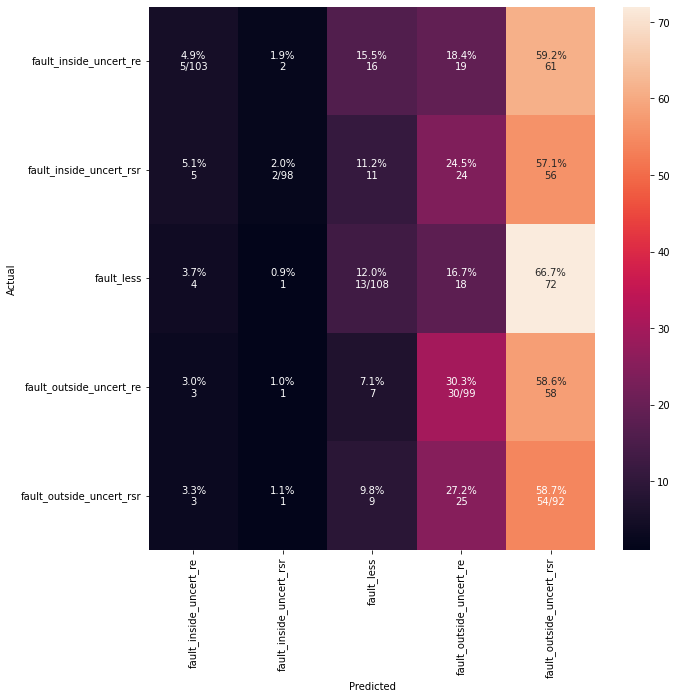

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show()

cm_analysis(y_test, y_pred, classifier.classes_, ymap=None, figsize=(10,10))